### Experiment on long-context instruction tuning dataset auto-generation based on CNKI papers in Chinese

**`Self-Instruct`**: 

**`LangChain`**:

**`Autogen`**:

#### step0. prepare the environment and the dependencies

In [1]:
import sys
sys.path.append("../src/")
import os
import json
import re

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv()) # openai_api_key

# from tqdm import tqdm
from tqdm.notebook import tqdm

import numpy as np
import langchain
import openai
import autogen
import seaborn as sns

In [20]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.memory import ConversationBufferMemory
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

#### step1. build up a vector store for the raw pdf papers

In [17]:
data_root = "./data/cnki_papers_zh_mini/"
chunk_size = 1000
chunk_overlap = 0

In [18]:
# laod the pdf into doc objects
pdf_loaders = [PyPDFLoader(os.path.join(data_root, filename)) for filename in os.listdir(data_root) if filename.endswith(".pdf")]
# define the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

In [19]:
docs = []
for loader in tqdm(pdf_loaders): docs.extend(loader.load())
print(len(docs))
docs[:5]

  0%|          | 0/4 [00:00<?, ?it/s]

Multiple definitions in dictionary at byte 0x1c64c3 for key /MediaBox
Multiple definitions in dictionary at byte 0x1565a4 for key /MediaBox
Multiple definitions in dictionary at byte 0x26bbe for key /GSP1
Multiple definitions in dictionary at byte 0x26d72 for key /GSP1
Multiple definitions in dictionary at byte 0x26f04 for key /GSP1
Multiple definitions in dictionary at byte 0x270ad for key /GSP1
Multiple definitions in dictionary at byte 0x27234 for key /GSP1
Multiple definitions in dictionary at byte 0x273d1 for key /GSP1
Multiple definitions in dictionary at byte 0x2756f for key /GSP1
Multiple definitions in dictionary at byte 0x27701 for key /GSP1
Multiple definitions in dictionary at byte 0x278b7 for key /GSP1
Multiple definitions in dictionary at byte 0x27a6d for key /GSP1
Multiple definitions in dictionary at byte 0x27c0f for key /GSP1
Multiple definitions in dictionary at byte 0x27dce for key /GSP1
Multiple definitions in dictionary at byte 0x27fbf for key /GSP1
Multiple defini

50


[Document(page_content="No. 1, 2021 / Serial No.307\u3000\u3000随着移动通信技术的快速发展，移动智能终端的\n迅速普及，互联网商业模式的迭代创新，移动互联网\n已经深度嵌入到人们的学习、工作和生活场景。截至\n2019 年 12 月，我国网民规模达 9.04 亿，手机网民\n规模为 8.97 亿，我国国内市场上监测到的 App 数量\n为 367 万款[1]。如今人们越来越依赖智能手机等电子\n设备，并且将 App 作为生活中的必需品，通过 App\n进行通讯社交、购物支付、旅游住宿、资讯阅读、健身运动等。截至 2019 年 12 月，15~19 岁手机网民\n群体人均手机 App 数量最多，达 84 个；60 岁及以上\n手机网民群体人均手机 App 数量也有 37 个[1]。 App\n已成为收集、存储、处理和使用个人信息最为常见，也是最为重要的工具。App 在给用户生活带来便利的\n同时，也引起了用户对 App 信息安全、隐私风险等的\n担忧。中国消费者协会曾对 App 个人信息泄露情况开\n展问卷调查，调查结果显示：个人信息泄露情况相当严重，信息泄露途径和表现形式多样，消费者缺乏有\n效的保护手段\n[2]。中国消费者协会对 1 0类 共1 0 0款大数据时代读者个人信息保护的实践逻辑与规\n范路径*\n—— 以图书类 App 隐私政策文本为视角\n徐  磊\u3000郭  旭\n[ 摘\u3000要 ]\u3000 本文以 10 款排名靠前的图书类 App 隐私政策为研究对象，从个人信息的收集和使用、个人信息的存储和保护、读者\n个人信息权利等维度，对相关隐私政策文本进行分析。虽然运营商愈发重视隐私政策，但是隐私政策依然存在重点不明、规定模\n糊、利益偏向等问题。为了完善现有隐私政策和保护读者个人信息，应当提升读者在隐私政策制定和修订过程中的参与度；增强\n隐私政策的显著性和通俗性；夯实隐私政策法律基础，推动隐私政策迭代优化；提高隐私政策质量，注重未成年人信息保障；构建多元协同治理体系，确保隐私政策贯彻落实。\n[ 关键词 ]\u3000 个人信息保护\u3000图书\u3000隐私政策\u3000App\n[ 中图分类号 ]\u3000 G252 \u3000\u3000[ 文献分类号 ]\u

In [16]:
vectorstore = Chroma(
    collection_name="full_documents",
    embedding_function=OpenAIEmbeddings()
)
vectorstore.add_documents(docs)
vectorstore

In [89]:
retriever = vectorstore.as_retriever(
    search_type="mmr", # maximum marginal relevance
    search_kwargs={"lambda_mult": 0.25}) # the higher the value, the higher the diversity and the lower the relevance

#### step2. set up a conversational retrieval QA chain for the documents

In [66]:
rag_chain = ConversationalRetrievalChain.from_llm(
    OpenAI(model="gpt-3.5-turbo", temperature=0),
    retriever,
    memory=ConversationBufferMemory(memory_key="chat_history", return_messages=True)
)

In [30]:
from langchain.evaluation.qa.generate_prompt import PROMPT
PROMPT

PromptTemplate(input_variables=['doc'], template='You are a teacher coming up with questions to ask on a quiz. \nGiven the following document, please generate a question and answer based on that document.\n\nExample Format:\n<Begin Document>\n...\n<End Document>\nQUESTION: question here\nANSWER: answer here\n\nThese questions should be detailed and be based explicitly on information in the document. Begin!\n\n<Begin Document>\n{doc}\n<End Document>')

#### step3. build a qa generation chain to generate the seed instructions

In [67]:
from langchain.prompts import PromptTemplate
gen_prompt_template_str = "You are a teacher coming up with questions to ask on a quiz. \n\
Given the following document, please generate a bunch of question and answer pairs based on that document in the language of {language}.\n\n\
Example Format:\n<Begin Document>\n...\n<End Document>\n\
QUESTIONS:\nquestions here organized as a list of strings seperated by newlines\nANSWERS:\ncorresponding answers here organized as a list of strings seperated by newlines respectively\n\n\
These questions should be detailed and be based explicitly on extractive information, synthetic knowledge, important relationship, casual reasoning, etc in the document. \n\
REMEMBER: all the generated questions and answers should use the language of {language}, except those like terms or abbreviations that are not used in {language} in that document.\n\
Begin!\n\n<Begin Document>\n{doc}\n<End Document>"

print(len(gen_prompt_template_str), '\n')
print(gen_prompt_template_str, '\n')

gen_prompt_template = PromptTemplate(input_variables=["doc"], template=gen_prompt_template_str)
gen_prompt_template

830 

You are a teacher coming up with questions to ask on a quiz. 
Given the following document, please generate a bunch of question and answer pairs based on that document in the language of {language}.

Example Format:
<Begin Document>
...
<End Document>
QUESTIONS:
questions here organized as a list of strings seperated by newlines
ANSWERS:
corresponding answers here organized as a list of strings seperated by newlines respectively

These questions should be detailed and be based explicitly on extractive information, synthetic knowledge, important relationship, casual reasoning, etc in the document. 
REMEMBER: all the generated questions and answers should use the language of {language}, except those like terms or abbreviations that are not used in {language} in that document.
Begin!

<Begin Document>
{doc}
<End Document> 



PromptTemplate(input_variables=['doc', 'language'], template='You are a teacher coming up with questions to ask on a quiz. \nGiven the following document, please generate a bunch of question and answer pairs based on that document in the language of {language}.\n\nExample Format:\n<Begin Document>\n...\n<End Document>\nQUESTIONS:\nquestions here organized as a list of strings seperated by newlines\nANSWERS:\ncorresponding answers here organized as a list of strings seperated by newlines respectively\n\nThese questions should be detailed and be based explicitly on extractive information, synthetic knowledge, important relationship, casual reasoning, etc in the document. \nREMEMBER: all the generated questions and answers should use the language of {language}, except those like terms or abbreviations that are not used in {language} in that document.\nBegin!\n\n<Begin Document>\n{doc}\n<End Document>')

In [68]:
from langchain.output_parsers.regex import RegexParser
gen_output_parser = RegexParser(
    regex=r"QUESTIONS:\n((?:.*?\n)+)ANSWERS:\n((?:.*?\n)+)",
    output_keys=["questions", "answers"],
)
gen_output_parser

RegexParser(regex='QUESTIONS:\\n((?:.*?\\n)+)ANSWERS:\\n((?:.*?\\n)+)', output_keys=['questions', 'answers'])

In [69]:
from langchain.evaluation.qa import QAGenerateChain

language_map = {
    "zh": "CHINESE",
    "en": "ENGLISH"
}

gen_bot = ChatOpenAI(
    model='gpt-3.5-turbo-1106', # 16k
    temperature=0.05, 
)

gen_chain = QAGenerateChain(
    llm=gen_bot,
    prompt=gen_prompt_template,
    output_parser=gen_output_parser,
)

In [149]:
gen_samples_zh = gen_chain.apply([{"doc": doc, "language": language_map['en']} for doc in docs])

In [155]:
print(len(gen_samples_zh), '\n')

gen_samples_zh

50 



[{'qa_pairs': {'questions': '1. 什么是移动互联网？\n2. 2019年12月，中国的网民规模是多少？\n3. 15~19岁手机网民群体人均手机 App 数量最多是多少？\n4. App 在用户生活中扮演了什么样的角色？\n5. 中国消费者协会对App个人信息泄露情况进行了怎样的调查？\n6. 本文的研究对象是什么？\n7. 运营商对隐私政策的态度如何？\n8. 为了保护读者个人信息，应当采取哪些措施？\n9. 本文的关键词有哪些？\n10. 本文的研究成果是哪个项目的成果？\n\n',
   'answers': '1. 移动互联网是指移动通信技术的快速发展，移动智能终端的迅速普及，互联网商业模式的迭代创新，移动互联网已经深度嵌入到人们的学习、工作和生活场景。\n2. 2019年12月，中国的网民规模达到了9.04亿。\n3. 15~19岁手机网民群体人均手机 App 数量最多达到了84个。\n4. App在用户生活中扮演了通讯社交、购物支付、旅游住宿、资讯阅读、健身运动等角色。\n5. 中国消费者协会对App个人信息泄露情况进行了问卷调查，结果显示个人信息泄露情况相当严重，信息泄露途径和表现形式多样，消费者缺乏有效的保护手段。\n6. 本文的研究对象是10款排名靠前的图书类App的隐私政策。\n7. 运营商对隐私政策的态度是虽然重视，但是隐私政策依然存在重点不明、规定模糊、利益偏向等问题。\n8. 为了保护读者个人信息，应当提升读者在隐私政策制定和修订过程中的参与度；增强隐私政策的显著性和通俗性；夯实隐私政策法律基础，推动隐私政策迭代优化；提高隐私政策质量，注重未成年人信息保障；构建多元协同治理体系，确保隐私政策贯彻落实。\n9. 本文的关键词有个人信息保护、图书、隐私政策、App。\n'}},
 {'qa_pairs': {'questions': '1. 什么是App个人信息保护情况进行测评发现？\n2. 为什么隐私政策被称为隐私声明、隐私保护政策或隐私保护协议？\n3. 隐私政策主要围绕运营商如何收集、存储、处理和保护用户个人信息展开吗？\n4. 为什么用户协议可能对用户个人信息保护作出规定？\n5. 隐私政策可以提高用户的信任程度吗？\n6. 隐私政策可以规范运营商的信息处理行为吗？\n7. 隐私政策已成为运营商对用户个人信

#### step4. format the qa pairs into instructions

In [156]:
cnt = 0
for i, sample in enumerate(gen_samples_zh):
    qa_pairs = sample['qa_pairs']
    q_list, a_list = qa_pairs['questions'].split('\n'), qa_pairs['answers'].split('\n')
    print("="*25, f" For doc {i+1} ", "="*25)
    for j, q, a in zip(range(len(q_list)), q_list, a_list):
        print("-"*30)
        print(f"question{j+1}: ", q.strip('\n'))
        print(f"answer{j+1}: ", a.strip('\n'))
        cnt += 1
    
    print()

print(f"There are `{cnt}` quesion-asnwer pairs generated in total")

=========================  For doc 1  =========================
------------------------------
question1:  1. 什么是移动互联网？
answer1:  1. 移动互联网是指移动通信技术的快速发展，移动智能终端的迅速普及，互联网商业模式的迭代创新，移动互联网已经深度嵌入到人们的学习、工作和生活场景。
------------------------------
question2:  2. 2019年12月，中国的网民规模是多少？
answer2:  2. 2019年12月，中国的网民规模达到了9.04亿。
------------------------------
question3:  3. 15~19岁手机网民群体人均手机 App 数量最多是多少？
answer3:  3. 15~19岁手机网民群体人均手机 App 数量最多达到了84个。
------------------------------
question4:  4. App 在用户生活中扮演了什么样的角色？
answer4:  4. App在用户生活中扮演了通讯社交、购物支付、旅游住宿、资讯阅读、健身运动等角色。
------------------------------
question5:  5. 中国消费者协会对App个人信息泄露情况进行了怎样的调查？
answer5:  5. 中国消费者协会对App个人信息泄露情况进行了问卷调查，结果显示个人信息泄露情况相当严重，信息泄露途径和表现形式多样，消费者缺乏有效的保护手段。
------------------------------
question6:  6. 本文的研究对象是什么？
answer6:  6. 本文的研究对象是10款排名靠前的图书类App的隐私政策。
------------------------------
question7:  7. 运营商对隐私政策的态度如何？
answer7:  7. 运营商对隐私政策的态度是虽然重视，但是隐私政策依然存在重点不明、规定模糊、利益偏向等问题。
------------------------------
question8:  8. 为了保护读者个人信息，应当采取哪些措施？


In [159]:
gen_instructions_zh = []

split_prompt_zh = "<文档{idx}>"

instruction_sample_template = {
    "instruction": "",
    "input": "",
    "output": "",
    "metadata": {},
}

qa_order_prefix_pattern = r'^\d+\.\s'


for i, sample in tqdm(enumerate(gen_samples_zh), total=len(gen_samples_zh)):
    qa_pairs, doc = sample['qa_pairs'], docs[i]
    q_list, a_list = qa_pairs['questions'].split('\n'), qa_pairs['answers'].split('\n')
    
    relative_docs = {d.page_content:d for d in retriever.invoke(doc.page_content)} # relative to the doc generating the qa pairs
    
    for q, a in zip(q_list, a_list):
        q, a = re.sub(qa_order_prefix_pattern, '', q), re.sub(qa_order_prefix_pattern, '', a)
        context_docs = dict(**relative_docs)
        context_docs.update({d.page_content:d for d in retriever.invoke(q)}) # relative to the question only
        context_docs.update({d.page_content:d for d in retriever.invoke(a)}) # relative to the answer only
        
        context_keys = list(context_docs.keys()); np.random.shuffle(context_keys)
        context = "\n\n".join([split_prompt_zh.format(idx=idx+1) + '\n' + d for idx, d in enumerate(context_keys)]) # relative to original doc, question and the answer
        metadata = {split_prompt_zh.format(idx=idx+1) : context_docs[d].metadata for idx, d in enumerate(context_keys)}
        
        instruction_sample = dict(**instruction_sample_template)
        instruction_sample['instruction'] = q
        instruction_sample['output'] = a
        instruction_sample['input'] = context
        instruction_sample['metadata'] = metadata
        
        gen_instructions_zh.append(instruction_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

In [160]:
alpaca_template_zh = "给定以下一个描述某种任务的指令，以及由若干篇文档组成的输入以提供相关上下文信息，请根据上下文，恰当回答指令中的问题或请求\n\n### 指令:\n{instruction}\n\n### 输入:\n{input}\n\n### 回答:\n{output}"

for i, sample in enumerate(gen_instructions_zh[:3]):
    instruction = sample["instruction"]
    input = sample["input"]
    output = sample["output"]
    
    prompt = alpaca_template_zh.format(instruction=instruction, input=input, output=output)
    
    print("="*25, f" prompt {i+1}", "="*25)
    print(prompt)
    

=========================  prompt 1 =========================
给定以下一个描述某种任务的指令，以及由若干篇文档组成的输入以提供相关上下文信息，请根据上下文，恰当回答指令中的问题或请求

### 指令:
什么是移动互联网？

### 输入:
<文档1>
No. 1, 2021 / Serial No.307　　随着移动通信技术的快速发展，移动智能终端的
迅速普及，互联网商业模式的迭代创新，移动互联网
已经深度嵌入到人们的学习、工作和生活场景。截至
2019 年 12 月，我国网民规模达 9.04 亿，手机网民
规模为 8.97 亿，我国国内市场上监测到的 App 数量
为 367 万款[1]。如今人们越来越依赖智能手机等电子
设备，并且将 App 作为生活中的必需品，通过 App
进行通讯社交、购物支付、旅游住宿、资讯阅读、健身运动等。截至 2019 年 12 月，15~19 岁手机网民
群体人均手机 App 数量最多，达 84 个；60 岁及以上
手机网民群体人均手机 App 数量也有 37 个[1]。 App
已成为收集、存储、处理和使用个人信息最为常见，也是最为重要的工具。App 在给用户生活带来便利的
同时，也引起了用户对 App 信息安全、隐私风险等的
担忧。中国消费者协会曾对 App 个人信息泄露情况开
展问卷调查，调查结果显示：个人信息泄露情况相当严重，信息泄露途径和表现形式多样，消费者缺乏有
效的保护手段
[2]。中国消费者协会对 1 0类 共1 0 0款大数据时代读者个人信息保护的实践逻辑与规
范路径*
—— 以图书类 App 隐私政策文本为视角
徐  磊　郭  旭
[ 摘　要 ]　 本文以 10 款排名靠前的图书类 App 隐私政策为研究对象，从个人信息的收集和使用、个人信息的存储和保护、读者
个人信息权利等维度，对相关隐私政策文本进行分析。虽然运营商愈发重视隐私政策，但是隐私政策依然存在重点不明、规定模
糊、利益偏向等问题。为了完善现有隐私政策和保护读者个人信息，应当提升读者在隐私政策制定和修订过程中的参与度；增强
隐私政策的显著性和通俗性；夯实隐私政策法律基础，推动隐私政策迭代优化；提高隐私政策质量，注重未成年人信息保障；构建多元协同治理体系，确保隐私政策贯彻落实。
[ 关键词 ]　

number: 390 | min length: 6279 | average length: 15933 | max length: 27906



<Axes: ylabel='Count'>

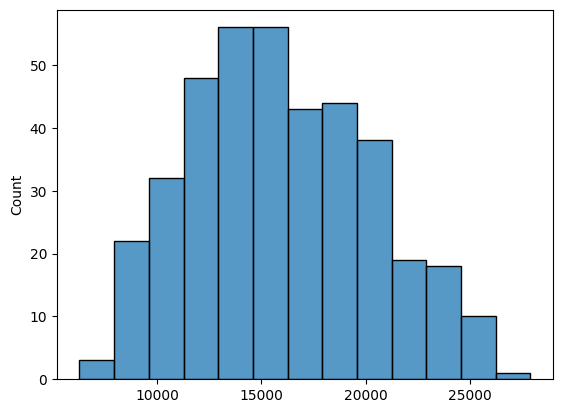

In [162]:
lens = [len(instr['instruction']) + len(instr['input']) + len(instr['output']) for instr in gen_instructions_zh]
print(f"number: {len(gen_instructions_zh)} | min length: {np.min(lens)} | average length: {np.mean(lens):.0f} | max length: {np.max(lens)}\n")

sns.histplot(lens)

In [163]:
gen_data_save_root = os.path.join(data_root, 'gen_data')
if not os.path.exists(gen_data_save_root): os.makedirs(gen_data_save_root)

# save prompt template
template_save_path = os.path.join(gen_data_save_root, 'alpaca_template.json')
with open(template_save_path, 'w', encoding='utf-8') as f:
    json.dump({'prompt_with_input_zh': alpaca_template_zh}, f, ensure_ascii=False, indent=4)

# save the qa pairs from the qa chain as the seed instructions
seed_instructions_save_path = os.path.join(gen_data_save_root, 'seed_instructions_zh.json')
with open(seed_instructions_save_path, 'w', encoding='utf-8') as f:
    json.dump(gen_instructions_zh, f, ensure_ascii=False, indent=4)

#### step5.1 bootstrap the instructions from the seed ones

In [112]:
# load the seed instructions from the seed pool
with open(seed_instructions_save_path, 'r', encoding='utf-8') as f:
    seed_instructions_zh = json.load(f)

In [171]:
print(len(os.listdir(data_root)))
os.listdir(data_root)

4


['大数据时代读者个人信息保护...类App隐私政策文本为视角_徐磊.pdf',
 '人工智能时代学生数据隐私保护的动因与策略_侯浩翔.pdf',
 '基于知识库增强深度学习模型...究—从完整性与语义冲突角度_朱侯.pdf',
 '基于BERT文本分类模型的...PP隐私政策完整性评价研究_朱侯.pdf']

In [169]:
print(len(os.listdir('./data/cnki_papers_zh/')))
os.listdir('./data/cnki_papers_zh/')

82


['在线健康社区社交氛围对用户持续知识分享意愿的影响研究_万君.pdf',
 '在线付费问答平台用户持续使用行为影响因素研究_李睿智.pdf',
 '基于社会影响理论的在线健康社区用户知识分享行为研究_周涛.pdf',
 '影响个人在线提供隐私信息意愿的实证研究_王洪伟.pdf',
 '移动终端APP隐私政策内容分析_孟霞.pdf',
 '学术虚拟社区特征对知识交流效果影响的研究_袁勤俭.pdf',
 '信息表征对移动医疗APP隐...响研究——基于认知负荷理论_张玥.pdf',
 '手机APP隐私政策的可读性研究_秦克飞.pdf',
 '用户社交媒体的使用与隐私保护研究_邹晓艳.pdf',
 '我国移动阅读应用个人信息保护政策合规性测度研究_张艳丰.pdf',
 '员工的主动性人格与创新行为...感与知识分享能力的调节作用_张振刚.pdf',
 '知识问答社区用户心流体验对...研究——以PAT模型为视角_李颖.pdf',
 '社会化问答社区知乎的用户持续使用行为影响因素研究_王哲.pdf',
 '基于知识发酵的虚拟学术社区...共享影响要素与实现机理研究_王东.pdf',
 '论学术虚拟社区知识交流模式_丁敬达.pdf',
 '企业隐私政策的影响及其机制...—基于用户视角的综述与展望_高充彦.pdf',
 '在线隐私政策对消费者提供个...究——信息敏感度的调节作用_梁晓丹.pdf',
 '虚拟学术社区用户持续使用行为影响因素研究_周前钱.pdf',
 '中外移动APP用户隐私保护文本比较研究_刘娇.pdf',
 '虚拟学术社区知识共享实现机制研究_王东.pdf',
 '学术虚拟社区用户知识交流行为影响因素调查研究_孙富杰.pdf',
 '大数据时代读者个人信息保护...类App隐私政策文本为视角_徐磊.pdf',
 '社交媒体用户隐私政策阅读意愿实证研究_朱侯.pdf',
 'APP隐私政策用户友好度评价研究_姚胜译.pdf',
 '教育类App隐私保护评价指标构建和保护现状研究_李青.pdf',
 '企业隐私政策的影响及其机制...—基于用户视角的综述与展望_高充彦 (1).pdf',
 '虚拟学术社区中科研人员合作...法与实证研究法相结合的视角_谭春辉.pdf',
 '组态视角下社交型问答社区用...径研究——基于社会生态框架_王莉雅.pdf',
 '